In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE, ADASYN
import shap

In [2]:
diabetes = pd.read_csv('../../CSVs/cleaned_diabetes.csv')
diabetes = diabetes.drop(columns={'Unnamed: 0'})
diabetes.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,...,change_yes,change_no,diabetesMed_yes,diabetesMed_no,age_encoding,glu_serum_encoding,A1C_encoded,total_visits,polypharmacy,num_meds_chanaged
0,1,41,0,1,0,0,0,1,No,No,...,0,1,0,1,0,0,0,0,0,0
1,3,59,0,18,0,0,0,9,No,No,...,1,0,1,0,1,0,0,0,1,1
2,2,11,5,13,2,0,1,6,No,No,...,0,1,1,0,2,0,0,3,1,0
3,2,44,1,16,0,0,0,7,No,No,...,1,0,1,0,3,0,0,0,1,1
4,1,51,0,8,0,0,0,5,No,No,...,1,0,1,0,4,0,0,0,1,0


In [3]:
X = diabetes.drop(columns=['readmitted'])
y = diabetes['readmitted'] # what we're predicting

In [4]:
X = X.rename(columns={'number_inpatient': 'Number of Inpatient Visits',\
    'discharge_status_Discharged to home':'Discharged to Home', 'discharge_status_Expired':'Expired',\
    'total_visits':'Total Visits', 'diabetesMed_yes':'Prescribed Diabetes Med', \
    'time_in_hospital':'Time in Hospital', 'number_diagnoses':'Number of Diagnoses',\
    'num_lab_procedures':'Number of Lab Procedures', 'discharge_status_Discharged/transferred to another rehab fac including rehab units of a hospital.':\
        'Discharged/Transferred to Another Rehab Facility'})

In [5]:
# 80% train, 10% validation, 10% test
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [6]:
# We also need to encode the medication! 
meds = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone'
]

med_encoding = {'No':0,'Down':1,'Steady':2,'Up':3}
for col in meds:
    if col in X_train.columns:
        X_train[col] = X_train[col].map(med_encoding).fillna(0).astype(int)
        X_val[col] = X_val[col].map(med_encoding).fillna(0).astype(int)
        X_test[col] = X_test[col].map(med_encoding).fillna(0).astype(int)
        X[col] = X[col].map(med_encoding).fillna(0).astype(int)

combo_meds = ['glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone']

for df in [X, X_train, X_val, X_test]:
    df['combo_med'] = 0
    for med in combo_meds:
        if med in df.columns:
            df['combo_med'] += df[med]
    df['combo_med'] = (df['combo_med'] > 0).astype(int)
    df.drop(columns=[med for med in combo_meds if med in df.columns], inplace=True)


In [7]:
X.columns

Index(['Time in Hospital', 'Number of Lab Procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'Number of Inpatient Visits', 'Number of Diagnoses', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glu_tested', 'A1C_tested', 'race_Caucasian',
       'race_AA', 'race_unknown', 'race_Hispanic', 'race_other', 'race_Asian',
       'gender_male', 'gender_female', 'admission_type_Elective',
       'admission_type_Emergency', 'admission_type_Newborn',
       'admission_type_Trauma Center', 'admission_type_Unknown',
       'admission_type_Urgent', 'Discharged to Home',
       'discharge_status_Discharged/transferred to ICF',
       'discharge_status_Discharged/transferred to SNF',
       'Discharged/Transferred to Another Rehab Facilit

In [8]:
# X = X.drop(columns=[col for col in X.columns if col.startswith('discharge_status_')])

In [9]:
# X_train = X_train.drop(columns=[col for col in X_train.columns if col.startswith('discharge_status_')])
# X_val = X_val.drop(columns=[col for col in X_val.columns if col.startswith('discharge_status_')])
# X_test = X_test.drop(columns=[col for col in X_test.columns if col.startswith('discharge_status_')])

In [10]:
xgb_model = XGBClassifier(
    subsample= 0.7956447755377811,
    n_estimators = 527,
    min_child_weight = 2,
    max_depth = 3,
    learning_rate = 0.037281761570859454,
    colsample_bytree = 0.8093574700581173,
    scale_pos_weight = 5,
    use_label_encoder = False,
    eval_metric = 'logloss',
    random_state = 42
)
xgb_model.fit(X_train, y_train)
y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))

y_proba = xgb_model.predict_proba(X_val)[:, 1]
thresh = 0.33
y_pred = (y_proba >= thresh).astype(int)
print("Classification Report:\n", classification_report(y_val, y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:16:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Accuracy: 0.8157067033615097
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.50      0.65      9039
           1       0.16      0.76      0.26      1135

    accuracy                           0.53     10174
   macro avg       0.55      0.63      0.46     10174
weighted avg       0.85      0.53      0.61     10174



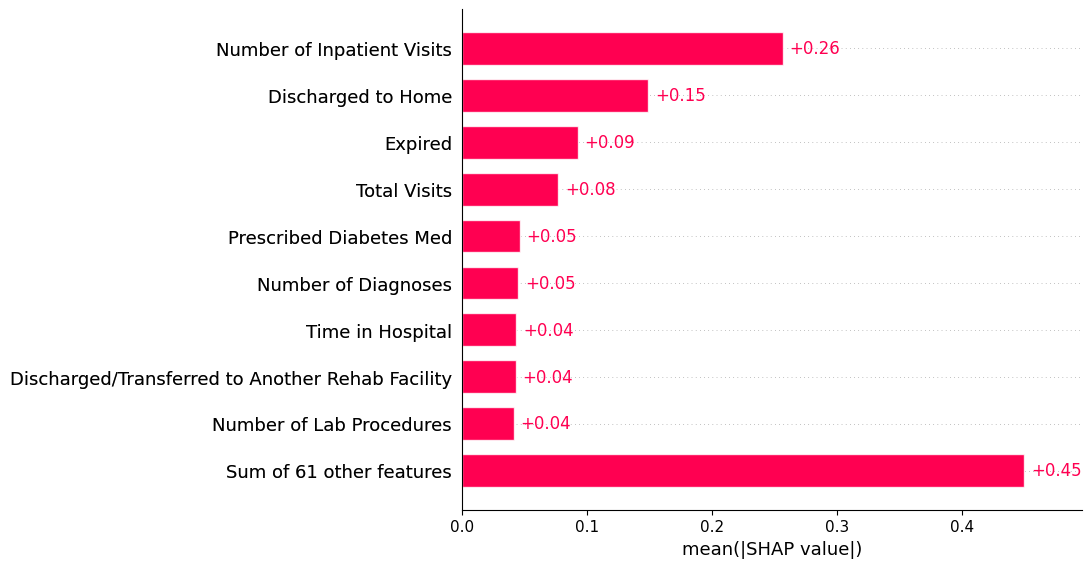

In [11]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X.copy())

shap.plots.bar(shap_values)

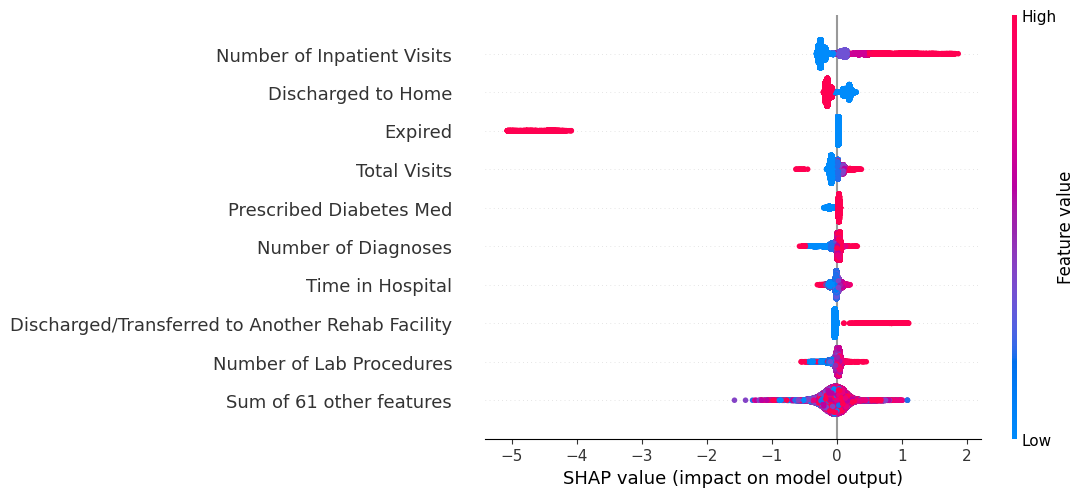

In [12]:
shap.plots.beeswarm(shap_values)

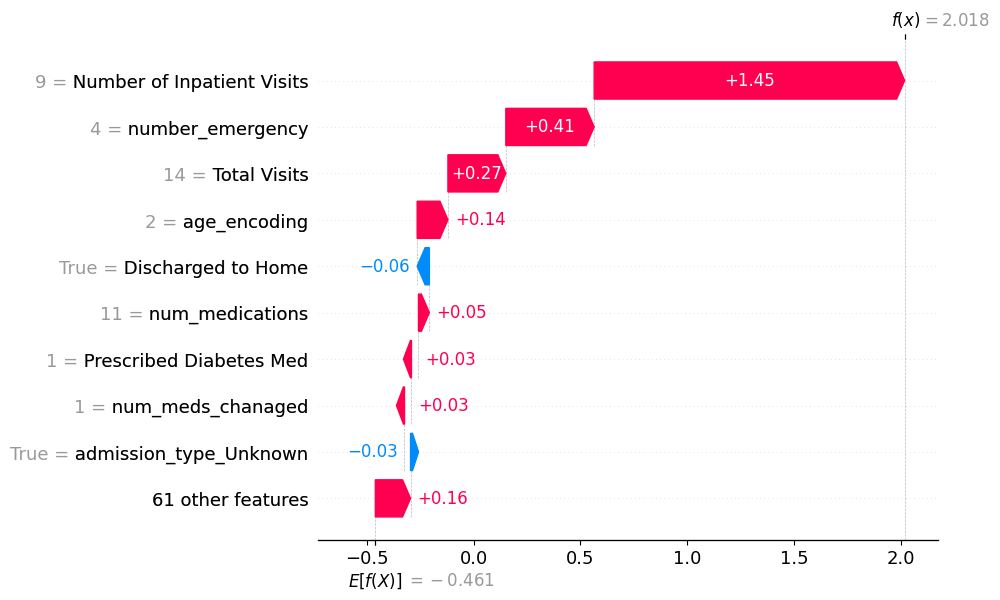

In [13]:
shap.plots.waterfall(shap_values[24887])

In [14]:
correct = np.where((y_pred == y_val) & (y_pred == 1))[0]

In [15]:
y_val.iloc[95]

np.int64(1)

In [16]:
X_val.iloc[95]

Time in Hospital             1
Number of Lab Procedures    49
num_procedures               0
num_medications              4
number_outpatient            0
                            ..
A1C_encoded                  0
Total Visits                 2
polypharmacy                 0
num_meds_chanaged            0
combo_med                    0
Name: 1512, Length: 70, dtype: object

In [17]:
result_df = X_val.iloc[correct].copy()
result_df["true_label"] = y_val.iloc[correct].values
result_df["predicted_label"] = y_pred[correct]
result_df["predicted_proba"] = y_proba[correct]

result_df = result_df.sort_values(by='predicted_proba', ascending=False)
result_df

,Time in Hospital,Number of Lab Procedures,num_procedures,num_medications,number_outpatient,number_emergency,Number of Inpatient Visits,Number of Diagnoses,metformin,repaglinide,...,age_encoding,glu_serum_encoding,A1C_encoded,Total Visits,polypharmacy,num_meds_chanaged,combo_med,true_label,predicted_label,predicted_proba
24887,6,24,1,11,1,4,9,9,0,0,...,2,3,0,14,1,1,0,1,1,0.882692
88052,1,43,0,6,2,2,15,3,0,0,...,2,0,0,19,1,1,0,1,1,0.850638
81140,2,10,0,4,1,0,11,3,0,0,...,2,0,0,12,0,1,0,1,1,0.849515
90199,3,9,0,14,0,10,8,9,0,0,...,4,0,0,18,1,1,0,1,1,0.836020
45910,3,38,2,15,1,2,9,9,0,0,...,3,0,0,12,1,0,0,1,1,0.833082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84040,14,39,0,14,0,1,1,9,3,0,...,4,0,0,2,1,2,0,1,1,0.331646
12624,7,45,3,24,0,0,0,7,0,0,...,5,0,0,0,1,0,0,1,1,0.331459
32991,2,64,0,7,0,0,1,5,2,0,...,7,0,1,1,1,0,0,1,1,0.331043
74767,5,61,1,22,0,0,0,9,0,0,...,8,0,0,0,1,0,0,1,1,0.330401


In [18]:
result_df.iloc[0].to_csv('patient.csv')